<h1> CHURN PREDICTION for SaaS using ML



<h2> Project Objective : </h2>

To build and compare several machine learning models (Softmax Regression, SVM, Random Forest) to predict a customer's churn risk score (1-5) and identify the key drivers of churn.

Importing all necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

<h2> Data loading and initial inspection

In [2]:
train_df = pd.read_csv("train.csv")
train_df.head()

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,fffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,...,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,2
1,fffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,...,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,1
2,fffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,...,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,5
3,fffe43004900440036003000330031003600,Eufemia Cardwell,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,...,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,5
4,fffe43004900440031003900350030003600,Meghan Kosak,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,...,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,5


In [3]:
train_df.describe()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
count,36992.000000,36992.000000,36992.000000,36992.000000,33549.000000,36992.000000
mean,37.118161,-41.915576,243.472334,29271.194003,686.882199,3.463397
std,15.867412,228.819900,398.289149,19444.806226,194.063624,1.409661
min,10.000000,-999.000000,-2814.109110,800.460000,-760.661236,-1.000000
25%,23.000000,8.000000,60.102500,14177.540000,616.150000,3.000000
50%,37.000000,12.000000,161.765000,27554.485000,697.620000,4.000000
75%,51.000000,16.000000,356.515000,40855.110000,763.950000,5.000000
max,64.000000,26.000000,3235.578521,99914.050000,2069.069761,5.000000


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   36992 non-null  object 
 1   Name                          36992 non-null  object 
 2   age                           36992 non-null  int64  
 3   gender                        36992 non-null  object 
 4   security_no                   36992 non-null  object 
 5   region_category               31564 non-null  object 
 6   membership_category           36992 non-null  object 
 7   joining_date                  36992 non-null  object 
 8   joined_through_referral       36992 non-null  object 
 9   referral_id                   36992 non-null  object 
 10  preferred_offer_types         36704 non-null  object 
 11  medium_of_operation           36992 non-null  object 
 12  internet_option               36992 non-null  object 
 13  l

In [5]:
train_df.isnull().sum()

,0
customer_id,0
Name,0
age,0
gender,0
security_no,0
region_category,5428
membership_category,0
joining_date,0
joined_through_referral,0
referral_id,0


<h2> Exploratory Data Analysis (EDA) & Visualization

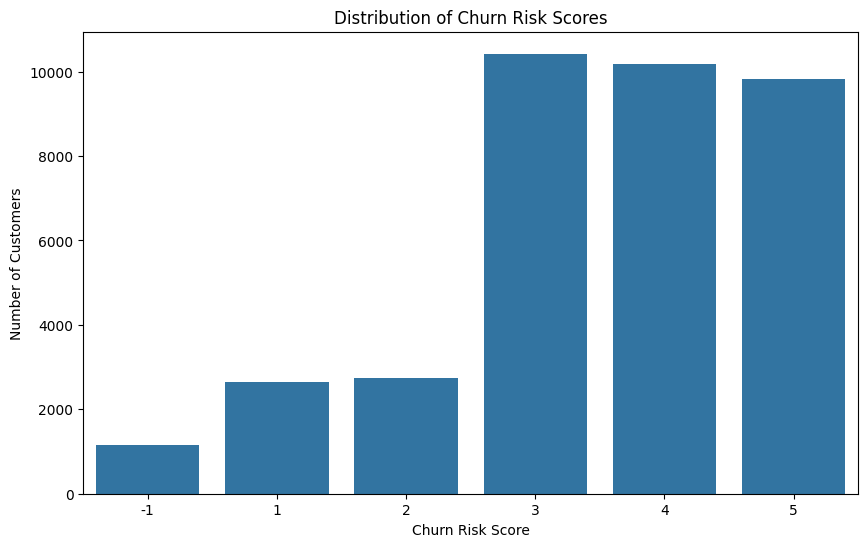

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(x='churn_risk_score', data=train_df)
plt.title('Distribution of Churn Risk Scores')
plt.xlabel('Churn Risk Score')
plt.ylabel('Number of Customers')
plt.show()

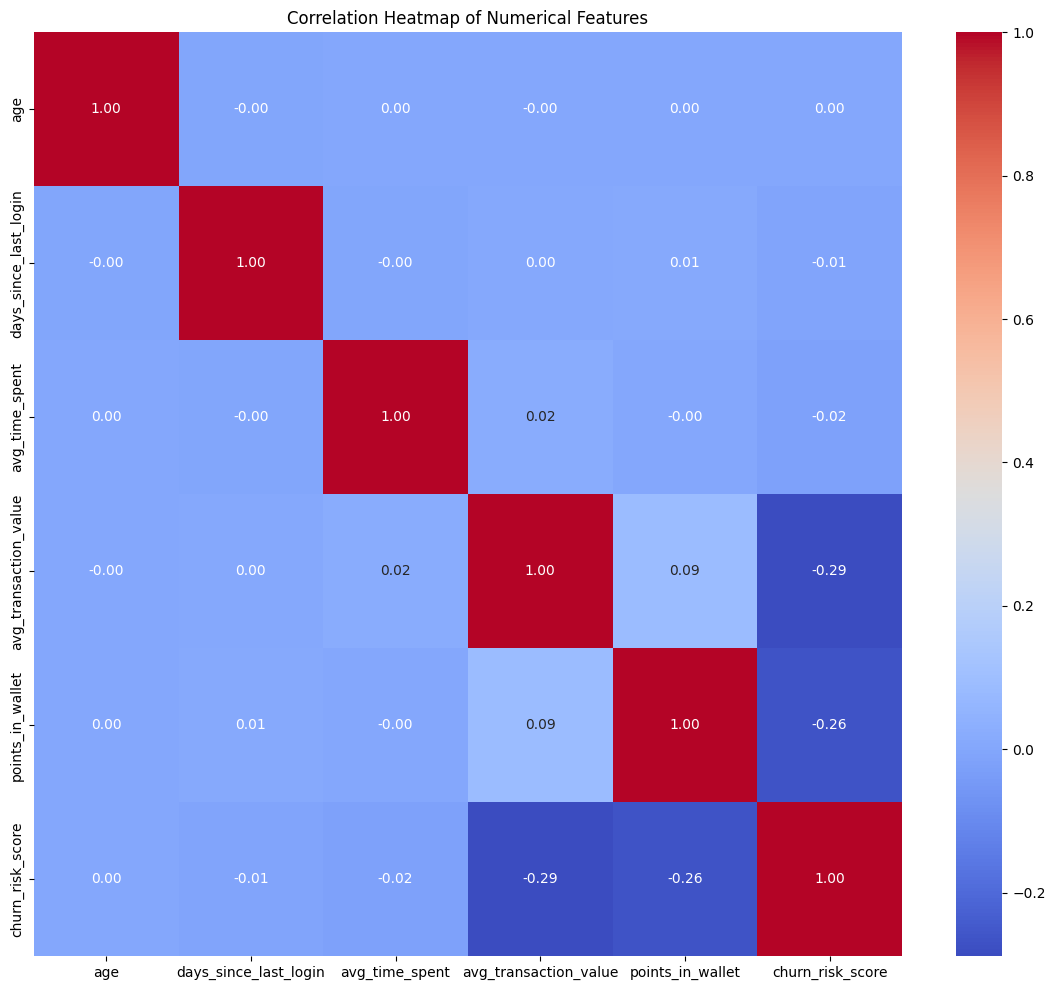

In [7]:
# Select only numerical columns from your dataframe
numerical_df = train_df.select_dtypes(include=np.number)

plt.figure(figsize=(14, 12))
sns.heatmap(numerical_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

<h2>Train-test split

In [8]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = train_df.drop(columns=['churn_risk_score'])
y = train_df['churn_risk_score']

# Filter out rows where churn_risk_score is -1
valid_indices = y[y != -1].index
X = X.loc[valid_indices]
y = y[valid_indices]

# Split into train/validation sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

<h2>Data Preprocessing & Feature Engineering

To fill the null values we will add 'None' to categorical columns null values and mean of the present values for numerical columns

In [9]:
# Fill null values in X_train and X_test separately after the split
for col in X_train.columns:
    if X_train[col].isnull().sum() != 0:
        if X_train[col].dtype == 'object':
            # Fill categorical columns with mode
            X_train[col].fillna(X_train[col].mode()[0], inplace=True)
        elif X_train[col].dtype == 'float64' or X_train[col].dtype == 'int64':
            # Fill numerical columns with mean
            X_train[col].fillna(X_train[col].mean(), inplace=True)

for col in X_test.columns:
    if X_test[col].isnull().sum() != 0:
        if X_test[col].dtype == 'object':
            # Fill categorical columns with mode
            X_test[col].fillna(X_test[col].mode()[0], inplace=True)
        elif X_test[col].dtype == 'float64' or X_test[col].dtype == 'int64':
            # Fill numerical columns with mean
            X_test[col].fillna(X_test[col].mean(), inplace=True)

In [10]:
X_train.isnull().sum()

,0
customer_id,0
Name,0
age,0
gender,0
security_no,0
region_category,0
membership_category,0
joining_date,0
joined_through_referral,0
referral_id,0


Dropping unnecessary columns -- customer_id, Name, security_no, referral_id

In [11]:
X_train = X_train.drop(labels = ['customer_id','Name','security_no','referral_id'], axis=1)
X_test = X_test.drop(labels = ['customer_id','Name','security_no','referral_id'], axis=1)

In [12]:
from datetime import datetime

def add_tenure(df):
    df = df.copy()
    df['joining_date'] = pd.to_datetime(df['joining_date'])
    df['tenure_days'] = (datetime.now() - df['joining_date']).dt.days
    df.drop(columns=['joining_date'], inplace=True)
    return df


In [13]:
X_train = add_tenure(X_train)
X_test = add_tenure(X_test)

In [14]:
X_train.head()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,tenure_days
6660,35,F,City,Basic Membership,?,Without Offers,Desktop,Mobile_Data,12:51:39,-999,1175.956109,4248.84,16.0,515.150000,No,Yes,Yes,Unsolved,No reason specified,3488
30915,34,M,Town,Platinum Membership,No,Gift Vouchers/Coupons,Smartphone,Wi-Fi,14:34:44,14,252.020000,26946.21,23.0,686.470434,No,Yes,Yes,Solved in Follow-up,No reason specified,2970
10995,39,M,Town,Platinum Membership,?,Credit/Debit Card Offers,Smartphone,Fiber_Optic,18:52:18,18,258.690000,6032.17,30.81782670410314,796.990000,Yes,No,Yes,Solved in Follow-up,User Friendly Website,3047
25663,14,M,Town,No Membership,No,Gift Vouchers/Coupons,Desktop,Wi-Fi,16:17:42,15,307.370000,41719.14,Error,698.240000,No,Yes,Yes,No Information Available,Poor Product Quality,3129
22292,63,M,Town,Premium Membership,No,Gift Vouchers/Coupons,Desktop,Wi-Fi,18:02:49,-999,52.680000,1775.36,13.0,784.280000,Yes,No,Yes,No Information Available,Poor Website,3235


we have days_since_last_login and tenure_days column so it is safe to drop last_visit_time column as it would not provide any deeper insights for churn prediction in saas business

In [15]:
X_train = X_train.drop(['last_visit_time'],axis = 1)
X_test = X_test.drop(['last_visit_time'],axis = 1)

<h2> converting categorical columns to numerical

In [16]:
for col in X_test.columns:
    if X_train[col].dtype=='object':
        print(col)

gender
region_category
membership_category
joined_through_referral
preferred_offer_types
medium_of_operation
internet_option
avg_frequency_login_days
used_special_discount
offer_application_preference
past_complaint
complaint_status
feedback


one interesting column is feedback we can use NLP to convert this categorical column to numerical

In [17]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [18]:
paragraph=[]
for line in X_train['feedback']:
    paragraph.append(line)

In [19]:
wordnet=WordNetLemmatizer()

In [20]:
corpus=[]

for i in range(len(paragraph)):
    review=re.sub('[^a-zA-Z]',' ',paragraph[i])
    review=review.lower()
    review=review.split()
    review=[wordnet.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    review=' '.join(review)
    corpus.append(review)

In [21]:
xx = pd.DataFrame(corpus)
xx.columns=['name']
xx.head()

,name
0,reason specified
1,reason specified
2,user friendly website
3,poor product quality
4,poor website


In [22]:
xx['name'].nunique()

9

In [23]:
feedback=xx['name'].unique()
feedback

array(['reason specified', 'user friendly website',
       'poor product quality', 'poor website', 'poor customer service',
       'many ad', 'reasonable price', 'quality customer care',
       'product always stock'], dtype=object)

In [24]:
for i in range(9):
    xx.replace(feedback[i],i,inplace=True)
xx.head()

,name
0,0
1,0
2,1
3,2
4,3


In [25]:
df1=pd.DataFrame({'1':xx['name'],'2':X_train['feedback']})
df1.head(15)

,1,2
0,0.0,NaN
1,0.0,Quality Customer Care
2,1.0,NaN
3,2.0,Poor Website
4,3.0,Poor Website
5,1.0,No reason specified
6,4.0,NaN
7,2.0,NaN
8,4.0,Poor Customer Service
9,5.0,NaN


In [26]:
X_train['feedback']=xx['name']

In [27]:
X_train.head()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,tenure_days
6660,35,F,City,Basic Membership,?,Without Offers,Desktop,Mobile_Data,-999,1175.956109,4248.84,16.0,515.150000,No,Yes,Yes,Unsolved,4.0,3488
30915,34,M,Town,Platinum Membership,No,Gift Vouchers/Coupons,Smartphone,Wi-Fi,14,252.020000,26946.21,23.0,686.470434,No,Yes,Yes,Solved in Follow-up,NaN,2970
10995,39,M,Town,Platinum Membership,?,Credit/Debit Card Offers,Smartphone,Fiber_Optic,18,258.690000,6032.17,30.81782670410314,796.990000,Yes,No,Yes,Solved in Follow-up,0.0,3047
25663,14,M,Town,No Membership,No,Gift Vouchers/Coupons,Desktop,Wi-Fi,15,307.370000,41719.14,Error,698.240000,No,Yes,Yes,No Information Available,4.0,3129
22292,63,M,Town,Premium Membership,No,Gift Vouchers/Coupons,Desktop,Wi-Fi,-999,52.680000,1775.36,13.0,784.280000,Yes,No,Yes,No Information Available,5.0,3235


doing the same thing with feedback column of test data frame

In [28]:
paragraph=[]
for line in X_test['feedback']:
    paragraph.append(line)

In [29]:
corpus=[]

for i in range(len(paragraph)):
    review=re.sub('[^a-zA-Z]',' ',paragraph[i])
    review=review.lower()
    review=review.split()
    review=[wordnet.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    review=' '.join(review)
    corpus.append(review)


In [30]:
xx=pd.DataFrame({'name':corpus})

In [31]:
for i in range(9):
    xx.replace(feedback[i],i,inplace=True)
xx.head()

,name
0,3
1,4
2,5
3,0
4,3


In [32]:
df1=pd.DataFrame({'1':xx['name'],'2':X_test['feedback']})
df1.head(15)

,1,2
0,3.0,Products always in Stock
1,4.0,NaN
2,5.0,Poor Website
3,0.0,NaN
4,3.0,NaN
5,5.0,NaN
6,2.0,No reason specified
7,1.0,Poor Product Quality
8,2.0,NaN
9,0.0,Poor Customer Service


In [33]:
X_test['feedback']=xx['name']

In [34]:
X_test.head()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,tenure_days
29895,24,M,City,Silver Membership,Yes,Credit/Debit Card Offers,Smartphone,Fiber_Optic,7,35.770000,4464.88,Error,296.043399,Yes,No,No,Not Applicable,NaN,3552
25516,48,F,Town,No Membership,?,Without Offers,Desktop,Mobile_Data,18,923.216277,8799.31,21.0,601.320000,No,Yes,No,Not Applicable,NaN,3224
5723,46,M,Town,Silver Membership,No,Gift Vouchers/Coupons,Smartphone,Fiber_Optic,3,1049.422353,37963.34,15.0,738.120000,Yes,No,Yes,No Information Available,4.0,3804
98,42,F,City,No Membership,No,Gift Vouchers/Coupons,Both,Fiber_Optic,3,419.510000,14661.42,Error,404.489758,No,Yes,Yes,Solved in Follow-up,2.0,3412
27910,12,M,Town,Silver Membership,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,12,257.720000,45771.17,15.0,1221.121782,No,Yes,No,Not Applicable,NaN,3208


Now we have check if any categorical feature has more than 20 unique values , then we will omit that cause too much variety in data will simply make the dataset more complex to predict correctly.

In [35]:
for col in X_test.columns:
    if X_train[col].dtype=='object':
        if X_train[col].nunique() >20:
            X_train.drop(columns=[col], inplace=True)
            X_test.drop(columns=[col], inplace=True)
        else:
            k=0
            for val in X_train[col].value_counts().index:
                X_train[col].replace(val,k,inplace=True)
                X_test[col].replace(val,k,inplace=True)
                k+=1

In [36]:
X_train.head()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,tenure_days
6660,35,0,1,1,2,2,1,1,-999,1175.956109,4248.84,515.150000,1,0,1,3,4.0,3488
30915,34,1,0,5,0,0,0,0,14,252.020000,26946.21,686.470434,1,0,1,2,NaN,2970
10995,39,1,0,5,2,1,0,2,18,258.690000,6032.17,796.990000,0,1,1,2,0.0,3047
25663,14,1,0,0,0,0,1,0,15,307.370000,41719.14,698.240000,1,0,1,4,4.0,3129
22292,63,1,0,4,0,0,1,0,-999,52.680000,1775.36,784.280000,0,1,1,4,5.0,3235


let's remove NaN values in feedback column

In [37]:
# Fill NaN values in feedback column with the mode
X_train['feedback'].fillna(X_train['feedback'].mode()[0], inplace=True)
X_test['feedback'].fillna(X_test['feedback'].mode()[0], inplace=True)

In [38]:
X_train.isnull().sum()

,0
age,0
gender,0
region_category,0
membership_category,0
joined_through_referral,0
preferred_offer_types,0
medium_of_operation,0
internet_option,0
days_since_last_login,0
avg_time_spent,0


In [39]:
X_test.isnull().sum()

,0
age,0
gender,0
region_category,0
membership_category,0
joined_through_referral,0
preferred_offer_types,0
medium_of_operation,0
internet_option,0
days_since_last_login,0
avg_time_spent,0


In [40]:
from sklearn.preprocessing import StandardScaler

# Identify numerical columns
numerical_cols = X_train.select_dtypes(include=np.number).columns

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both training and test data
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

<h2>Encoding target variable

In [41]:
y_train.unique()

array([5, 3, 1, 2, 4])

In [42]:
y_train = y_train - 1

In [43]:
y_train.unique()

array([4, 2, 0, 1, 3])

In [44]:
y_test.unique()

array([4, 3, 5, 2, 1])

In [45]:
y_test = y_test - 1

In [46]:
!pip install imblearn

<h2> Modeling

<h3> Softmax Regression implementation

In [47]:
#Scratch implementation of softmax regression

class SoftmaxRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _one_hot(self, y, n_classes):
        """Converts a 1D array of labels into a one-hot encoded matrix."""
        one_hot_y = np.zeros((len(y), n_classes))
        one_hot_y[np.arange(len(y)), y] = 1
        return one_hot_y

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.n_classes = len(np.unique(y))

        # Initialize parameters
        self.weights = np.zeros((n_features, self.n_classes))
        self.bias = np.zeros((1, self.n_classes))
        y_one_hot = self._one_hot(y, self.n_classes)

        # Gradient Descent
        for _ in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted_proba = self._softmax(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted_proba - y_one_hot))
            db = (1 / n_samples) * np.sum(y_predicted_proba - y_one_hot, axis=0)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self._softmax(linear_model)

    def predict(self, X):
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

In [48]:
print("softmax regression from scratch")
model_softmax = SoftmaxRegression(learning_rate=0.1, n_iterations=1000)
model_softmax.fit(X_train, y_train)
y_pred_scratch = model_softmax.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_scratch)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_scratch))

softmax regression from scratch
Accuracy: 0.5823
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.22      0.32       530
           1       0.55      0.24      0.34       548
           2       0.63      0.75      0.68      2085
           3       0.43      0.46      0.44      2037
           4       0.70      0.73      0.72      1966

    accuracy                           0.58      7166
   macro avg       0.57      0.48      0.50      7166
weighted avg       0.58      0.58      0.57      7166



In [49]:
print("--- Training Logistic Regression (Scikit-learn) ---")
# The 'lbfgs' solver is a good default for multinomial problems.
model_sklearn_softmax = LogisticRegression(C = 0.001, class_weight = None, max_iter = 1000, penalty = 'l2', solver = 'saga')


model_sklearn_softmax.fit(X_train, y_train)
y_pred_sklearn = model_sklearn_softmax.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_sklearn)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_sklearn))

--- Training Logistic Regression (Scikit-learn) ---
Accuracy: 0.5848
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.15      0.24       530
           1       0.53      0.21      0.30       548
           2       0.61      0.75      0.67      2085
           3       0.42      0.30      0.35      2037
           4       0.66      0.92      0.77      1966

    accuracy                           0.58      7166
   macro avg       0.55      0.47      0.47      7166
weighted avg       0.56      0.58      0.55      7166



In [50]:
#finding the best parameters for softmax regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'saga'],
    'penalty': ['l2'],
    'max_iter': [500, 1000, 2000],
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(
    LogisticRegression(multi_class='multinomial'),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)


Best params: {'C': 0.001, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Best score: 0.5885634752048869


<h3> Random Forest and CART decision tree

In [51]:

import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report

class Node:
    """A helper class representing a single node in the decision tree."""
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value # Value if it's a leaf node

    def is_leaf_node(self):
        return self.value is not None

class DecisionTreeMultiClass:
    """A from-scratch implementation of a CART Decision Tree for multi-class classification."""
    def __init__(self, min_samples_split=2, max_depth=100):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None

    def _gini_impurity(self, y):
        """Calculates the Gini impurity of a set of labels."""
        # np.bincount is efficient for integer-labeled classes
        hist = np.bincount(y)
        ps = hist / len(y)
        return 1 - np.sum([p**2 for p in ps if p > 0])

    def _best_split(self, X, y):
        """Finds the best feature and threshold to split the data by maximizing information gain."""
        n_samples, n_features = X.shape
        if n_samples <= 1:
            return None, None

        parent_gini = self._gini_impurity(y)
        best_gain = -1
        split_idx, split_thresh = None, None

        for feat_idx in range(n_features):
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for thr in thresholds:
                left_idxs = np.where(X_column <= thr)[0]
                right_idxs = np.where(X_column > thr)[0]

                if len(left_idxs) == 0 or len(right_idxs) == 0:
                    continue

                n_l, n_r = len(left_idxs), len(right_idxs)
                gini_l, gini_r = self._gini_impurity(y[left_idxs]), self._gini_impurity(y[right_idxs])
                child_gini = (n_l / n_samples) * gini_l + (n_r / n_samples) * gini_r

                gain = parent_gini - child_gini
                if gain > best_gain:
                    best_gain, split_idx, split_thresh = gain, feat_idx, thr

        return split_idx, split_thresh

    def _grow_tree(self, X, y, depth=0):
        """Recursively builds the decision tree."""
        n_samples = len(y)

        if n_samples == 0:
            return Node(value=None) # Return None if no samples

        n_labels = len(np.unique(y))

        # Check stopping criteria to create a leaf node
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            # FIXED: Extract only the class label (integer) from the Counter result
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)

        best_feat, best_thresh = self._best_split(X, y)

        # If no gain, create a leaf node
        if best_feat is None:
            # FIXED: Extract only the class label (integer) from the Counter result
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)

        # Recursively grow child nodes
        left_idxs = np.where(X[:, best_feat] <= best_thresh)[0]
        right_idxs = np.where(X[:, best_feat] > best_thresh)[0]

        left = self._grow_tree(X[left_idxs], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def fit(self, X, y):
        """Starts the tree growing process."""
        self.root = self._grow_tree(X, y)

    def _traverse_tree(self, x, node):
        """Traverses the tree to predict a label for a single sample."""
        if node is None or node.is_leaf_node():
            return node.value if node else None

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def predict(self, X):
        """Predicts labels for a set of samples."""
        predictions = [self._traverse_tree(x, self.root) for x in X]
        return np.array(predictions)

In [52]:
print("--- Training Decision Tree (From Scratch) ---")
model_scratch_tree = DecisionTreeMultiClass(max_depth=10)
model_scratch_tree.fit(X_train.values, y_train.values) # Convert to NumPy arrays

y_pred_scratch = model_scratch_tree.predict(X_test.values) # Convert to NumPy arrays

accuracy = accuracy_score(y_test, y_pred_scratch)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_scratch))

--- Training Decision Tree (From Scratch) ---
Accuracy: 0.7322
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.58      0.67       530
           1       0.71      0.37      0.49       548
           2       0.77      0.89      0.83      2085
           3       0.72      0.55      0.62      2037
           4       0.70      0.90      0.79      1966

    accuracy                           0.73      7166
   macro avg       0.74      0.66      0.68      7166
weighted avg       0.73      0.73      0.72      7166



In [53]:
print("--- Training Random Forest (Scikit-learn) ---")
# n_estimators is the number of trees in the forest.
model_sklearn_rf = RandomForestClassifier(n_estimators =  181, max_depth = 28, min_samples_split = 4, min_samples_leaf = 2, max_features = 'sqrt')
model_sklearn_rf.fit(X_train.values, y_train.values) # Convert to NumPy arrays
y_pred_sklearn = model_sklearn_rf.predict(X_test.values) # Convert to NumPy arrays

accuracy = accuracy_score(y_test, y_pred_sklearn)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_sklearn))

--- Training Random Forest (Scikit-learn) ---
Accuracy: 0.7318
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.54      0.64       530
           1       0.69      0.38      0.49       548
           2       0.76      0.91      0.83      2085
           3       0.74      0.51      0.60      2037
           4       0.70      0.92      0.79      1966

    accuracy                           0.73      7166
   macro avg       0.74      0.65      0.67      7166
weighted avg       0.73      0.73      0.72      7166



In [54]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.5 MB/s eta 0:00:00


In [56]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import make_classification


def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 5, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # Define model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1,
    )

    # Cross-validation for robust evaluation
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy", n_jobs=-1).mean()

    return score


# --- Run Optuna Study ---
print("--- Starting Optuna Hyperparameter Optimization ---")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

# --- Results ---
print("\n--- Best Hyperparameters Found ---")
print(study.best_params)
print(f"Best cross-validation accuracy: {study.best_value:.4f}")

# --- Train Final Model using Best Hyperparameters ---
best_params = study.best_params
model_sklearn_rf = RandomForestClassifier(**best_params, random_state=42)
model_sklearn_rf.fit(X_train, y_train)

# --- Evaluate on Test Set ---
y_pred_sklearn = model_sklearn_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_sklearn)

from sklearn.metrics import classification_report
print(f"\nTest Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_sklearn))

[I 2025-10-26 13:46:22,714] A new study created in memory with name: no-name-b6c03ad2-cac4-4dfb-8d17-1bfb27914ec4


--- Starting Optuna Hyperparameter Optimization ---


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-10-26 13:47:15,070] Trial 0 finished with value: 0.742315676156401 and parameters: {'n_estimators': 189, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 0 with value: 0.742315676156401.
[I 2025-10-26 13:47:26,254] Trial 1 finished with value: 0.7253948682310775 and parameters: {'n_estimators': 267, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.742315676156401.
[I 2025-10-26 13:47:33,545] Trial 2 finished with value: 0.7306978745508607 and parameters: {'n_estimators': 118, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 0.742315676156401.
[I 2025-10-26 13:47:37,279] Trial 3 finished with value: 0.7372569540636768 and parameters: {'n_estimators': 64, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 0.742315676156401.
[I 202

In [57]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

print("--- Applying SMOTE to balance the training data ---")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)



# 2. Train your BEST model (from Optuna) on the NEW resampled data
print("\n--- Training Final Model on Resampled Data ---")
best_params = {
    'n_estimators': 181,
    'max_depth': 28,
    'min_samples_split': 4,
    'min_samples_leaf': 2,
    'max_features': 'sqrt'
}

final_model = RandomForestClassifier(**best_params, random_state=42)
final_model.fit(X_train_resampled, y_train_resampled)


# 3. Evaluate on the ORIGINAL, UNTOUCHED test set
print("\n--- Evaluating on the Original Test Set ---")
y_pred_final = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred_final)

print(f"Final Test Accuracy: {final_accuracy:.4f}")
print("Final Classification Report:")
print(classification_report(y_test, y_pred_final))

--- Applying SMOTE to balance the training data ---

--- Training Final Model on Resampled Data ---

--- Evaluating on the Original Test Set ---
Final Test Accuracy: 0.7284
Final Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.58      0.65       530
           1       0.71      0.36      0.48       548
           2       0.76      0.90      0.82      2085
           3       0.74      0.50      0.60      2037
           4       0.69      0.92      0.79      1966

    accuracy                           0.73      7166
   macro avg       0.73      0.65      0.67      7166
weighted avg       0.73      0.73      0.71      7166



## Feature Importance for Random Forest

Feature Importances (Random Forest):
membership_category             0.481384
points_in_wallet                0.378121
avg_transaction_value           0.124440
avg_time_spent                  0.004285
tenure_days                     0.002713
age                             0.002291
days_since_last_login           0.001830
feedback                        0.001228
preferred_offer_types           0.001008
medium_of_operation             0.000534
complaint_status                0.000513
region_category                 0.000460
internet_option                 0.000357
joined_through_referral         0.000333
gender                          0.000198
offer_application_preference    0.000113
used_special_discount           0.000108
past_complaint                  0.000086
dtype: float64


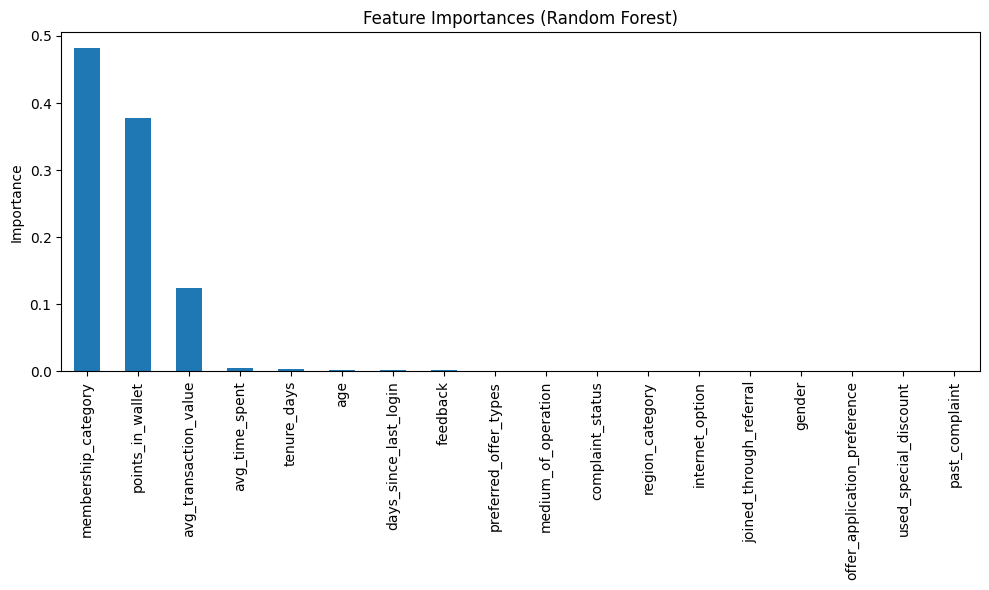

In [58]:

feature_importances = model_sklearn_rf.feature_importances_

feature_names = X_train.columns

feature_importance_series = pd.Series(feature_importances, index=feature_names)

sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

print("Feature Importances (Random Forest):")
print(sorted_feature_importances)

plt.figure(figsize=(10, 6))
sorted_feature_importances.plot(kind='bar')
plt.title("Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

<h3> Support Vector Machine (SVM)

In [59]:
print("--- Training Support Vector Machine (Scikit-learn) ---")
# The 'kernel' can be 'linear', 'poly', 'rbf', etc. 'rbf' is a good default.
# C is the regularization parameter.
model_sklearn_svm = SVC(kernel='rbf', C=1.0, random_state=42)
model_sklearn_svm.fit(X_train.values, y_train.values) # Convert to NumPy arrays
y_pred_sklearn = model_sklearn_svm.predict(X_test.values) # Convert to NumPy arrays

accuracy = accuracy_score(y_test, y_pred_sklearn)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_sklearn))

--- Training Support Vector Machine (Scikit-learn) ---
Accuracy: 0.6179
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.22      0.32       530
           1       0.57      0.28      0.38       548
           2       0.64      0.81      0.71      2085
           3       0.51      0.33      0.40      2037
           4       0.66      0.92      0.76      1966

    accuracy                           0.62      7166
   macro avg       0.60      0.51      0.51      7166
weighted avg       0.60      0.62      0.58      7166



In [60]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# --- Define Objective Function for SVM ---
def objective_svm(trial):
    # Define hyperparameter search space
    # These ranges are standard for SVM tuning
    C = trial.suggest_loguniform('C', 1e-2, 1e2)
    gamma = trial.suggest_loguniform('gamma', 1e-3, 1e-1)
    kernel = trial.suggest_categorical('kernel', ['rbf']) # RBF is usually best for this kind of problem

    # Define model
    model = SVC(
        C=C,
        gamma=gamma,
        kernel=kernel,
        random_state=42
    )

    # Cross-validation on the balanced training data for robust evaluation
    # Make sure you have X_train_resampled and y_train_resampled from your SMOTE step
    score = cross_val_score(model, X_train_resampled, y_train_resampled, cv=3, scoring="accuracy", n_jobs=-1).mean()

    return score


# --- Run Optuna Study ---
print("--- Starting Optuna Hyperparameter Optimization for SVM ---")
study_svm = optuna.create_study(direction="maximize")
study_svm.optimize(objective_svm, n_trials=30, show_progress_bar=True) # 30 trials is a good start

# --- Results ---
print("\n--- Best Hyperparameters Found for SVM ---")
print(study_svm.best_params)
print(f"Best cross-validation accuracy: {study_svm.best_value:.4f}")

# --- Train Final SVM using Best Hyperparameters on Resampled Data ---
best_svm_params = study_svm.best_params
model_sklearn_svm = SVC(**best_svm_params, random_state=42)
model_sklearn_svm.fit(X_train_resampled, y_train_resampled)

# --- Evaluate on the Original Test Set ---
y_pred_svm = model_sklearn_svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"\nTest Accuracy (Tuned SVM): {accuracy_svm:.4f}")
print("Classification Report (Tuned SVM):")
print(classification_report(y_test, y_pred_svm))

[I 2025-10-26 14:14:16,584] A new study created in memory with name: no-name-e0b9ff9d-36e9-4f89-8f35-86740e52195a


--- Starting Optuna Hyperparameter Optimization for SVM ---


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-10-26 14:16:36,444] Trial 0 finished with value: 0.5426072027076161 and parameters: {'C': 2.509267109963194, 'gamma': 0.007754142427226242, 'kernel': 'rbf'}. Best is trial 0 with value: 0.5426072027076161.
[I 2025-10-26 14:18:51,679] Trial 1 finished with value: 0.5629933562633204 and parameters: {'C': 1.8059135094842715, 'gamma': 0.01918033604441306, 'kernel': 'rbf'}. Best is trial 1 with value: 0.5629933562633204.
[I 2025-10-26 14:22:07,115] Trial 2 finished with value: 0.5998324697530688 and parameters: {'C': 52.80321510379913, 'gamma': 0.009907070831525224, 'kernel': 'rbf'}. Best is trial 2 with value: 0.5998324697530688.
[I 2025-10-26 14:24:34,246] Trial 3 finished with value: 0.5321742780897182 and parameters: {'C': 0.6825480728315132, 'gamma': 0.004266506169832003, 'kernel': 'rbf'}. Best is trial 2 with value: 0.5998324697530688.
[I 2025-10-26 14:26:52,704] Trial 4 finished with value: 0.5344527557804661 and parameters: {'C': 12.205495116210038, 'gamma': 0.00220060558400

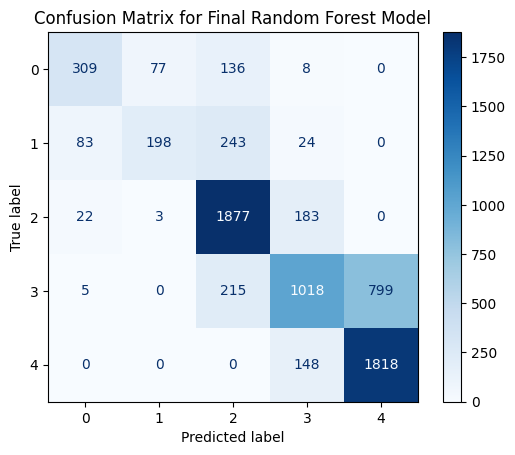

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 'final_model' is your best trained Random Forest
# 'X_test' and 'y_test' are your original, untouched test sets
y_pred_final = final_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_final)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Final Random Forest Model')
plt.show()

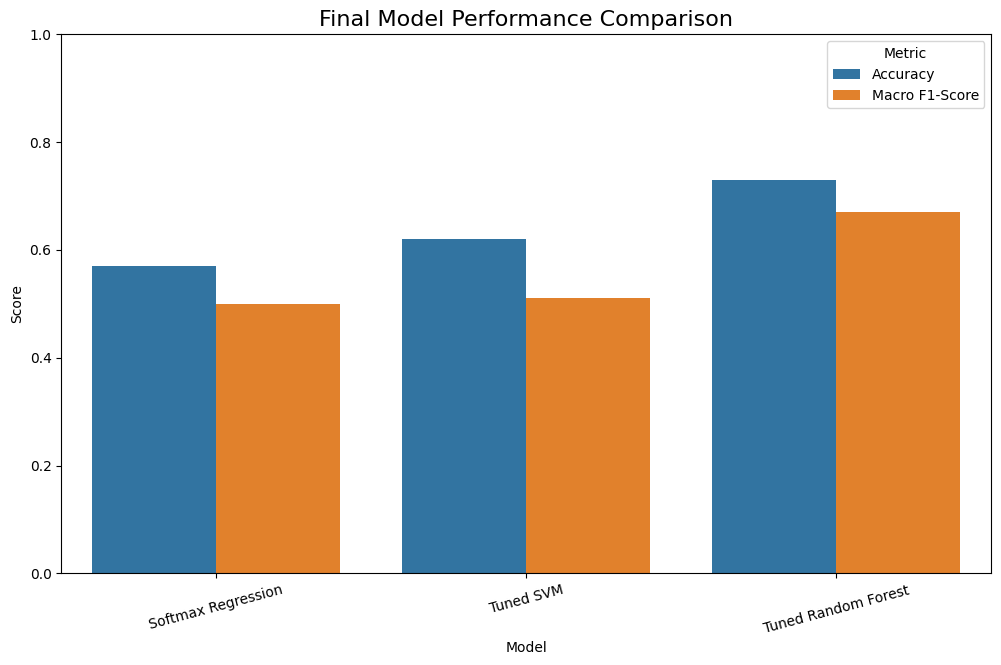

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dictionary with your final model results
# Replace these with your actual final scores
model_scores = {
    'Softmax Regression': {'Accuracy': 0.57, 'Macro F1-Score': 0.50},
    'Tuned SVM': {'Accuracy': 0.62, 'Macro F1-Score': 0.51}, # Use your tuned SVM score
    'Tuned Random Forest': {'Accuracy': 0.73, 'Macro F1-Score': 0.67} # Use your final RF score
}

# Convert to a DataFrame for easy plotting
scores_df = pd.DataFrame(model_scores).T.reset_index().rename(columns={'index': 'Model'})
scores_df_melted = scores_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plotting
plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Score', hue='Metric', data=scores_df_melted)
plt.title('Final Model Performance Comparison', fontsize=16)
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1.0) # Set y-axis from 0 to 1 for scores
plt.xticks(rotation=15)
plt.legend(title='Metric')
plt.show()